In [2]:
import numpy as np
import scipy.stats as si
import scipy.stats.mstats
import pandas as pd
import math
import matplotlib.pyplot as plt
from torch.quasirandom import SobolEngine
plt.style.use('seaborn')

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from scipy.stats.distributions import norm


In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [3]:
def BlackScholesExactSimulation(S, dts, r, sigma, numPath):
    out = []
    W = []
    
    if isinstance(S, np.ndarray) and len(S) == numPath:
        currentPath = S
    else:
        currentPath = np.ones(numPath) * S
        
    out.append(np.array(currentPath))

    for i in range(len(dts)-1):
        wPath = np.random.normal(0,1, int(numPath / 2))
        wPath = np.array([wPath, -wPath]).flatten()
        avgVar = np.var(wPath)
        wPath /= np.sqrt(avgVar)
        wPath -= np.average(wPath)
        W.append(np.array(wPath))
        dt = dts[i+1]-dts[i]
        currentPath *= np.exp((r - (sigma * sigma * 0.5))*dt + sigma * math.sqrt(dt) * wPath)
        out.append(np.array(currentPath))
    return (out, W)

def BlackScholesExactSimulationSobol(S, dts, r, sigma, numPath, scramble=False):
    out = []
    W = []
    
    if isinstance(S, np.ndarray) and len(S) == numPath:
        currentPath = S
    else:
        currentPath = np.ones(numPath) * S
        
    out.append(np.array(currentPath))

    engine = SobolEngine(len(dts)-1, scramble=scramble, seed=None)
    totalW = si.norm.ppf(np.array(engine.draw(numPath))*(1-2e-7)+1e-7)

    for i in range(len(dts)-1):
        wPath = totalW[:,i]
        wPath -= np.average(wPath)
        wPath /= np.sqrt(np.var(wPath))
        W.append(np.array(wPath))
        dt = dts[i+1]-dts[i]
        currentPath *= np.exp((r - (sigma * sigma * 0.5))*dt + sigma * math.sqrt(dt) * wPath)
        out.append(np.array(currentPath))
    return (out, W)

def BlackScholesStdDev(S, T, r, sigma):
    return np.sqrt(S * S * np.exp(2 * T * (r - sigma * sigma * 0.5)) * (np.exp(sigma * sigma * T) - 1.0))

def PriceEuroVanilla(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        
    return result

def PriceEuroVanillaDelta(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = si.norm.cdf(d1, 0.0, 1.0)
    if option == 'put':
        result =  - si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

def PriceEuroVanillaGamma(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    result = si.norm.pdf(d1, 0.0, 1.0)/(S*sigma*np.sqrt(T))

    return result

def PriceEuroVanillaVega(S, K, T, r, sigma, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    result = S * si.norm.pdf(d1, 0.0, 1.0) * math.sqrt(T)
        
    return result



def PriceBarrierOptions(S, K, r, sigma, T, H):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    nd1 = norm.cdf(d1, 0.0, 1.0)
    nd2 = norm.cdf(d2, 0.0, 1.0)
    nd1minus = norm.cdf(-d1, 0.0, 1.0)
    nd2minus = norm.cdf(-d2, 0.0, 1.0)

    l = (r + (sigma * sigma *0.5)) / (sigma * sigma)
    y = np.log((H*H)/(S*K)) / (sigma * np.sqrt(T)) + l * sigma * np.sqrt(T)
    x1 = np.log(S/H)/(sigma * np.sqrt(T))+l*sigma * np.sqrt(T)
    y1 = np.log(H/S)/(sigma * np.sqrt(T))+l*sigma * np.sqrt(T)

    c = S * nd1 - K * np.exp(-r*T) * nd2
    p = K * np.exp(-r*T) * nd2minus  - S * nd1minus
    cdi = S * (H/S)**(2*l) * norm.cdf(y) - K * np.exp(-r*T) * (H/S)**(2*l-2.0) * norm.cdf(y-sigma*np.sqrt(T))
    pdi = - S * norm.cdf(-x1) + K * np.exp(-r*T) * norm.cdf(-x1+sigma*np.sqrt(T)) 
    pdi +=  S*(H/S)**(2*l)*(norm.cdf(y)-norm.cdf(y1))
    pdi -= K*np.exp(-r*T)*(H/S)**(2*l-2.0)*(norm.cdf(y-sigma*np.sqrt(T))-norm.cdf(y1-sigma*np.sqrt(T))) 
    
    cdo = c - cdi
    pdo = p - pdi

    result=np.maximum([cdi,cdo,pdi,pdo], 0.0)

    return result 

In [4]:
S0 = 100.0
numPath = 20000
K = 100.0
r = 0.02
H = 90.0
sigma = 0.2
dts = [0.0, 0.5, 1.0]
T = dts[len(dts)-1]
grid = 100
dt = T / grid

spSim = np.linspace(0.0, T, num=grid)
spSim = np.sort(np.unique(np.hstack([spSim, dts])))

(SAll, WAll) = BlackScholesExactSimulationSobol(S0, spSim, r, sigma, numPath,scramble=False)
S = np.vstack([SAll[0], SAll[spSim.tolist().index(dts[1])], SAll[-1]])

ST = S[len(dts)-1]
vMax = np.vectorize(max)
payoff_cdo = vMax(ST - K, 0.0) * (np.min(SAll,axis=0) > H)
payoff_cdi = vMax(ST - K, 0.0) * (np.min(SAll,axis=0) < H)
payoff_pdo = vMax(K - ST, 0.0) * (np.min(SAll,axis=0) > H)
payoff_pdi = vMax(K - ST, 0.0) * (np.min(SAll,axis=0) < H)
disc = np.exp(-r*T)

PriceBarrierOptions(S0, K, r, sigma, T, H)

array([1.61559001, 7.30044727, 6.77194294, 0.16396166])

In [5]:
disc*np.mean(payoff_cdi), disc*np.mean(payoff_cdo), disc*np.mean(payoff_pdi), disc*np.mean(payoff_pdo)

(1.3594857713920552,
 7.4281244443547685,
 6.578446231910582,
 0.24085265748432735)

In [6]:
1-np.mean(1.0*(np.min(SAll,axis=0) > H))

0.5655

0.057121854713471976 0.011872266255893257 0.011872266255893257 0.011872266255893257
0.14293408393859863


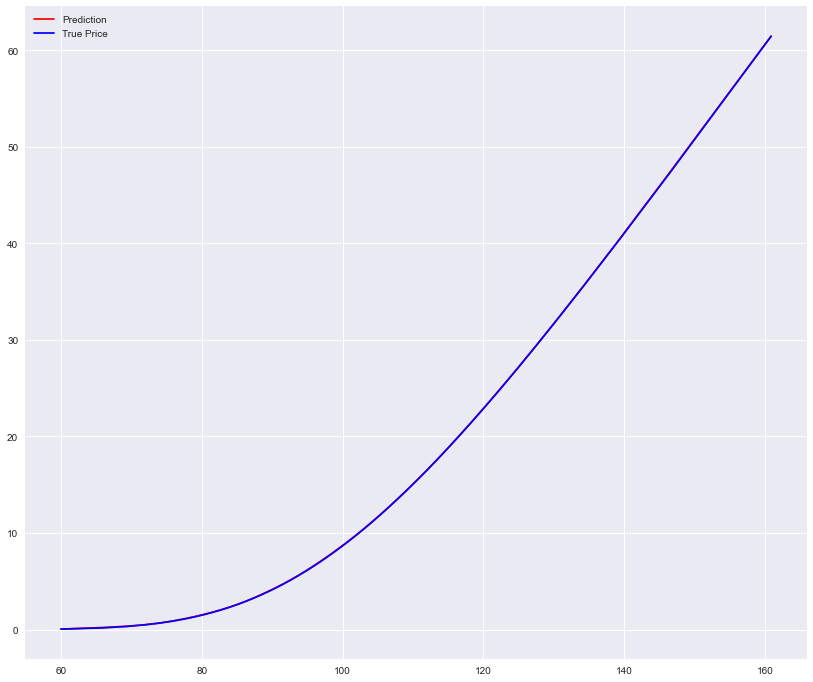

In [7]:
# Doing one conditional expectation step using kernel expectation and GPR with 2 steps and a control variate
import time

S0 = 100.0
numPath = 20000
K = 100.0
r = 0.01
sigma = 0.3
dts = [0.0, 0.5, 1.0]
T = dts[len(dts)-1]

spval = []
mse = []
abserr = []
#np.random.seed(0)

loops = 1

time_start = time.time()

for i in range(loops):
    (S, W) = BlackScholesExactSimulationSobol(S0, dts, r, sigma, numPath)

    sp = np.linspace(1, 99, num=50)
    sp = np.percentile(S[1],sp)

    ST = S[len(dts)-1]
    vMax = np.vectorize(max)
    payoff = vMax(ST - K, 0.0)

    #Silverman's rule of thumb
    payoff_stdev = math.sqrt(np.var(ST - S[1]))
    eps = 1.0 / (0.9 * payoff_stdev * numPath ** (-0.2))
    eps /= 2.0

    kout = []
    priceout = []
    varout = []
    covarout = []
    deltaout = []
    S2out = []
    derivout = []
    deriv2out = []

    for start in sp:
        k = np.exp(-eps * (S[1] - start)**2)
        kout.append(np.sum(k) + 1e-7)

    kRatio = max(kout) / kout
    kRatio = np.minimum(20.0, max(kout) / kout)

    #kernel regression
    for idx, start in enumerate(sp):
        epsBS = eps
        epsBS /= kRatio[idx]
        k = np.exp(-epsBS * (S[1] - start)**2)+ 1e-7
        diff = (S[1] - start)
        kd = k * diff
        kd2 = kd *  diff
        wll = k * np.sum(kd2) - diff * k * np.sum(kd)
        wllsum = np.sum(wll)

        kout.append(np.sum(k))
        yprice = payoff
        payoffDeriv = (ST / S[1]) * np.tanh(ST * 10.0 * payoff) * math.exp(-r*(dts[2]-dts[1]))
        payoffDeriv2 = (ST / S[1]) * 1.0 / np.sqrt(np.pi) * np.exp(-((ST-K)/1.0)**2) * math.exp(-r*(dts[2]-dts[1]))

        #Have to discount by the future price
        S2Avg = np.sum(S[2] * wll) / wllsum
        S2Avg *= math.exp(-r*(dts[2] - dts[1]))
        S2out.append(S2Avg)

        fitprice = np.sum(yprice*wll) / wllsum

        priceout.append(fitprice)
        derivout.append(np.sum(payoffDeriv*wll) / wllsum)
        deriv2out.append(np.sum(payoffDeriv2*wll) / wllsum)

        ycov = (payoff - fitprice) * (S[2] - S2Avg)
        covarout.append(np.sum(ycov*wll) / wllsum)
        y = (S[2] - S2Avg)**2
        varout.append(np.sum(y*wll) / wllsum)

    # fill NAs using forward fill
    beta = pd.array(np.array(covarout)/np.array(varout)).fillna(method='ffill').fillna(method='bfill')
    #beta = np.array(derivout)
    #beta = 0

    # Instantiate a Gaussian Process model, with an initial alpha of the full payoff sample std dev
    kernel = ConstantKernel(1.0, (1e-3, 1e10)) * Matern(0.5, (1e-3, 1e10))
    kernel += ConstantKernel(1.0, (1e-3, 1e10)) * Matern(1.5, (1e-3, 1e10))
    kernel += ConstantKernel(1.0, (1e-3, 1e10)) * Matern(2.5, (1e-3, 1e10))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0)

    # Fit to data using Maximum Likelihood Estimaton of the parameters
    gp.fit(np.atleast_2d(sp).T,  (np.array(priceout) + beta * (sp - S2out)))

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, gp_sigma = gp.predict(np.atleast_2d(sp).T, return_std=True)
    
    # Apply discounting to the predicted value
    y_pred = np.array(y_pred) * math.exp(-r*(dts[2] - dts[1]))

    truePrice = PriceEuroVanilla(sp, K, dts[2] - dts[1], r, sigma, option = 'call')
    trueDelta = PriceEuroVanillaDelta(sp, K, dts[2] - dts[1], r, sigma, option = 'call')
    trueGamma = PriceEuroVanillaGamma(sp, K, dts[2] - dts[1], r, sigma, option = 'call')
    mse.append(np.sqrt(np.var(y_pred - truePrice)))
    abserr.append(np.max(y_pred - truePrice))

time_end = time.time()
    
plt.figure(figsize = [14, 12])
plt.plot(np.atleast_2d(sp).T, y_pred, 'r', label='Prediction', )
plt.plot(np.atleast_2d(sp).T, truePrice, 'b', label='True Price')
#plt.plot(np.atleast_2d(sp).T, truePrice - np.array(priceout) * math.exp(-r*(dts[2] - dts[1])), 'b', label='Kernel')
#plt.plot(np.atleast_2d(sp).T, truePrice - np.array(priceout + beta * (sp - S2out)) * math.exp(-r*(dts[2] - dts[1])) , 'r', label='1st Order')
plt.legend()
#plt.plot(np.atleast_2d(sp).T, truePrice - (np.array(priceout + beta * (sp - S2out)) * math.exp(-r*(dts[2] - dts[1])) + 0.5 * np.array(deriv2out) * (sp - S2out)**2), 'm*', label='2nd Order')
#np.average(y_pred), np.average(truePrice), np.percentile(y_pred, 99), np.percentile(truePrice, 99), np.percentile(y_pred, 1), np.percentile(truePrice, 1)

kernelGPRError = (np.array(priceout) * math.exp(-r*(dts[2] - dts[1]))) - y_pred

print(np.average(abserr), np.average(mse), np.percentile(mse, 10.0), np.percentile(mse, 90.0))
print((time_end - time_start) / loops)


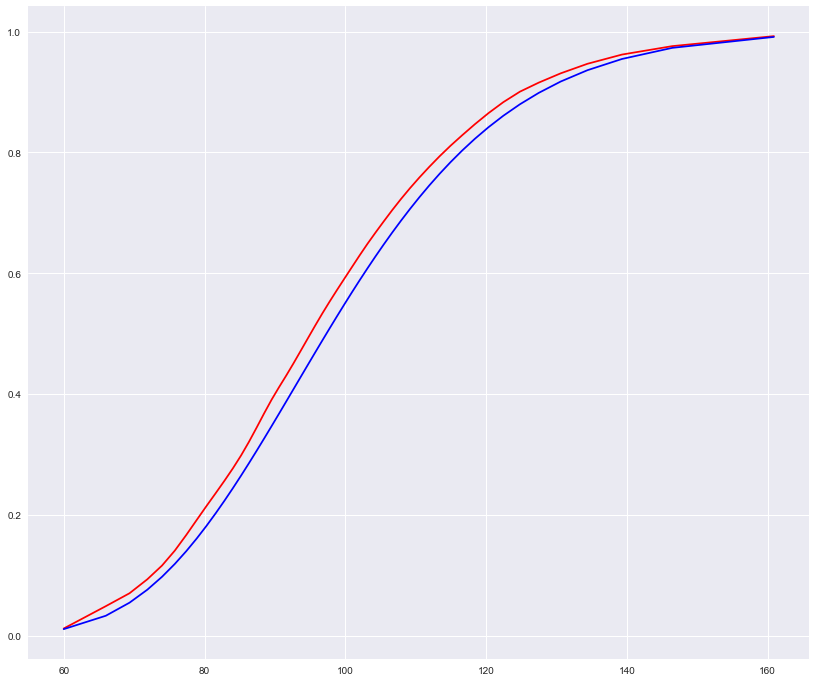

In [8]:
plt.figure(figsize = [14, 12])
plt.plot(sp, np.array(beta), 'r')
plt.plot(sp, trueDelta, 'b')

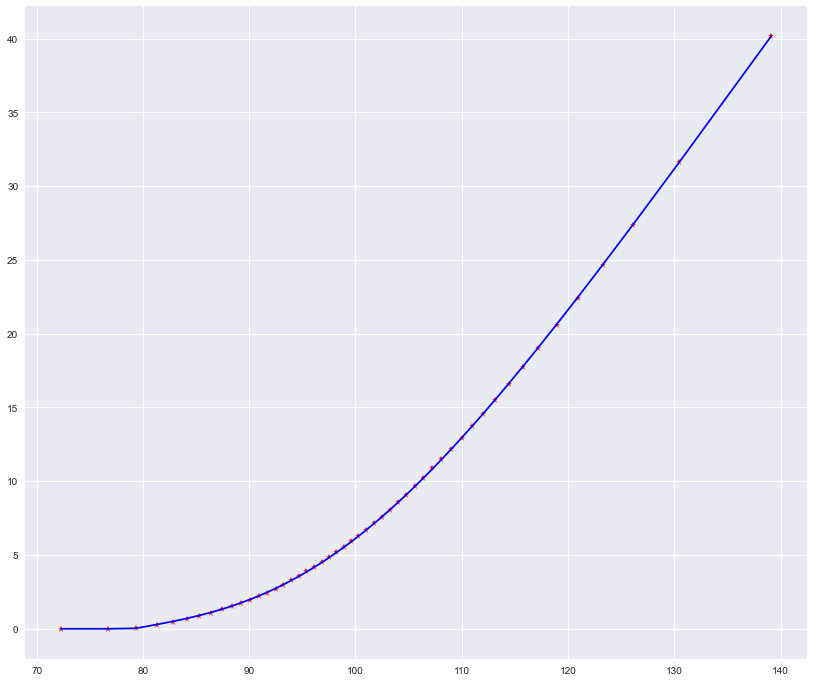

In [9]:
import time

S0 = 100.0
numPath = 100000
K = 100.0
r = 0.02
H = 80.0
sigma = 0.2
dts = [0.0, 0.5, 1.0]
T = dts[len(dts)-1]
grid = 100
dt = T / grid

spval = []
mse = []
abserr = []
#np.random.seed(0)

loops = 1

time_start = time.time()

spSim = np.linspace(0.0, T, num=grid)
spSim = np.sort(np.unique(np.hstack([spSim, dts])))

(SAll, WAll) = BlackScholesExactSimulationSobol(S0, spSim, r, sigma, numPath)
S = np.vstack([SAll[0], SAll[spSim.tolist().index(dts[1])], SAll[-1]])

sp = np.linspace(1.0, 99.0, num=50)
sp = np.percentile(S[1],sp)

ST = S[len(dts)-1]
vMax = np.vectorize(max)
payoff = vMax(ST - K, 0.0) * (np.min(SAll,axis=0) > H)

#Silverman's rule of thumb
payoff_stdev = math.sqrt(np.var(ST))
eps = 1.0 / (0.9 * payoff_stdev * numPath ** (-0.2))
eps /= 1.0

kout = []
priceout = []
varout = []
covarout = []
deltaout = []
S2out = []
derivout = []
deriv2out = []

for start in sp:
    k = np.exp(-eps * (S[1] - start)**2)
    kout.append(np.sum(k) + 1e-7)

kRatio = max(kout) / kout
kRatio = np.minimum(100.0, max(kout) / kout)

#kernel regression
for idx, start in enumerate(sp):
    epsBS = eps
    epsBS /= kRatio[idx]
    k = np.exp(-epsBS * (S[1] - start)**2) + 1e-10
    
    #excl anything that already knocked out
    k[np.min(SAll[0:np.argmin(spSim < dts[1])], axis=0) < H] = 0.0
    
    diff = (S[1] - start)
    kd = k * diff
    kd2 = kd *  diff
    wll = k * np.sum(kd2) - diff * k * np.sum(kd)
    wllsum = np.sum(wll) + 1e-10

    kout.append(np.sum(k))
    yprice = payoff
    payoffDeriv = (ST / S[1]) * np.tanh(ST * 10.0 * payoff) * math.exp(-r*(dts[2]-dts[1]))

    #Have to discount by the future price
    S2Avg = np.sum(S[2] * wll) / wllsum
    S2Avg *= math.exp(-r*(dts[2] - dts[1]))
    S2out.append(S2Avg)

    fitprice = np.sum(yprice*wll) / wllsum
    if start < H:
        fitprice = 0.0
        payoffDeriv = 0.0
    
    priceout.append(fitprice)
    derivout.append(np.sum(payoffDeriv*wll) / wllsum)

    ycov = (payoff - fitprice) * (S[2] - S2Avg)
    covarout.append(np.sum(ycov*wll) / wllsum)
    y = (S[2] - S2Avg)**2
    varout.append(np.sum(y*wll) / wllsum)
    # fill NAs using forward fill
    
#beta = pd.array(np.array(covarout)/np.array(varout)).fillna(method='ffill').fillna(method='bfill')
beta = np.array(derivout)
#beta = 0

# Instantiate a Gaussian Process model, with an initial alpha of the full payoff sample std dev
kernel = ConstantKernel(1.0, (1e-3, 1e10)) * Matern(1.5, (1e-3, 1e10))
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimaton of the parameters
gp.fit(np.atleast_2d(sp).T,  (np.array(priceout) + beta * (sp - S2out)))

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, gp_sigma = gp.predict(np.atleast_2d(sp).T, return_std=True)

# Apply discounting to the predicted value
y_pred = np.array(y_pred) * math.exp(-r*(dts[2] - dts[1]))

truePrice = PriceBarrierOptions(sp, K, r, sigma, dts[2] - dts[1], H * np.exp(-0.5826 * sigma * np.sqrt(dt)))[1]
#truePrice = PriceBarrierOptions(sp, K, r, sigma, dts[2] - dts[1], H)[1]

mse.append(np.sqrt(np.var(y_pred - truePrice)))
abserr.append(np.max(y_pred - truePrice))

plt.figure(figsize = [14, 12])
plt.plot(np.atleast_2d(sp).T, y_pred, 'r*', label='Prediction', )
plt.plot(np.atleast_2d(sp).T, truePrice, 'b', label='Prediction')
#plt.plot(np.atleast_2d(sp).T, np.array(priceout) * math.exp(-r*(dts[2] - dts[1])), 'g', label='Prediction')

In [10]:
gp.predict(np.atleast_2d([72,130]).T)

array([-1.09432951e-02,  3.14673091e+01])

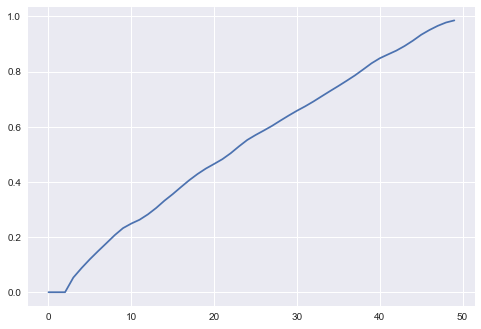

In [11]:
plt.plot(np.array(beta))